In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
dataset_path = '/content/drive/MyDrive/dataset/apnea-ecg-database-1.0.0/'
assert dataset_path.endswith('/')
print("Dataset path:", dataset_path)


Dataset path: /content/drive/MyDrive/dataset/apnea-ecg-database-1.0.0/


In [ ]:
!pip install -q wfdb biosppy peakutils


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.2/91.2 kB 712.9 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 163.8/163.8 kB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.0/158.0 kB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.0/12.0 MB 5.1 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires pandas==2.2.2, but you have pandas 2.3.2 which is incompatible.
cudf-cu12 25.6.0 requires pandas<2.2.4dev0,>=2.0, but you have pandas 2.3.2 which is incompatible.
dask-cudf-cu12 25.6.0 requires pandas<2.2.4dev0,>=2.0, but you have pandas 2.3.2 which is incompatible.


In [ ]:
import os, glob
import numpy as np
import wfdb
import matplotlib.pyplot as plt
from biosppy.signals import ecg
from scipy.signal import butter, filtfilt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.utils.class_weight import compute_class_weight
import tensorflow as tf

plt.rcParams['figure.figsize'] = (10,4)
print("Imports done")


Imports done


In [ ]:
dat_files = sorted(glob.glob(dataset_path + "*.dat"))
record_names = [os.path.splitext(os.path.basename(p))[0] for p in dat_files]
valid_records = [r for r in record_names if os.path.exists(os.path.join(dataset_path, r + ".apn"))]

print("Total .dat files:", len(record_names))
print("Valid records with annotations:", len(valid_records))
print("Examples:", valid_records[:10])


Total .dat files: 78
Valid records with annotations: 43
Examples: ['a01', 'a01r', 'a02', 'a02r', 'a03', 'a03r', 'a04', 'a04r', 'a05', 'a06']


In [ ]:
FS = 100
WINDOW_MIN = 60
SAMPLES_PER_WINDOW = FS * WINDOW_MIN


In [ ]:
from scipy.signal import butter, filtfilt

def butter_bandpass(lowcut, highcut, fs, order=4):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a

def bandpass_filter(sig, fs=100, low=0.5, high=40.0, order=4):
    b, a = butter_bandpass(low, high, fs, order=order)
    return filtfilt(b, a, sig)

FS = 100  # sampling frequency


In [ ]:
def extract_features_for_record(rec, use_qrs_if_available=True, fs=FS):
    path = os.path.join(dataset_path, rec)
    record = wfdb.rdrecord(path)
    ann_apn = wfdb.rdann(path, 'apn')
    sig = bandpass_filter(record.p_signal[:,0], fs=fs, low=0.5, high=40.0)

    if use_qrs_if_available and os.path.exists(path + ".qrs"):
        qrs = wfdb.rdann(path, 'qrs')
        rpeaks_all = np.asarray(qrs.sample, dtype=int)
    else:
        out = ecg.ecg(signal=sig, sampling_rate=fs, show=False)
        rpeaks_all = np.asarray(out['rpeaks'], dtype=int)

    X_rec, y_rec = [], []
    for i in range(len(ann_apn.sample)-1):
        start, end = int(ann_apn.sample[i]), int(ann_apn.sample[i+1])
        if end - start < fs*10: continue
        mask = (rpeaks_all >= start) & (rpeaks_all < end)
        r_local = rpeaks_all[mask] - start
        if len(r_local) < 3: continue
        rr = np.diff(r_local) / float(fs)
        if len(rr) < 2: continue
        mean_rr = float(np.mean(rr))
        hrv = float(np.std(rr))
        nn50 = int(np.sum(np.abs(np.diff(rr)) > 0.05))
        X_rec.append([mean_rr, hrv, nn50])
        y_rec.append(1 if ann_apn.symbol[i]=='A' else 0)

    return np.asarray(X_rec, np.float32), np.asarray(y_rec, np.int32)


In [ ]:
X_list, y_list = [], []
for rec in valid_records:
    try:
        Xi, yi = extract_features_for_record(rec)
        if len(Xi)==0:
            print(f"{rec}: no windows")
            continue
        X_list.append(Xi); y_list.append(yi)
        print(f"{rec}: {len(Xi)} windows")
    except Exception as e:
        print("Skipping", rec, "error:", e)

X = np.vstack(X_list)
y = np.concatenate(y_list)
print("Final dataset:", X.shape, y.shape, "positives:", int(y.sum()))

np.save(dataset_path + "X_features.npy", X)
np.save(dataset_path + "y_labels.npy", y)


a01: 488 windows
Skipping a01r error: Not enough beats to compute heart rate.
a02: 527 windows
Skipping a02r error: Not enough beats to compute heart rate.
a03: 518 windows
Skipping a03r error: Not enough beats to compute heart rate.
a04: 491 windows
Skipping a04r error: Not enough beats to compute heart rate.
a05: 453 windows
a06: 509 windows
a07: 510 windows
a08: 500 windows
a09: 494 windows
a10: 516 windows
a11: 465 windows
a12: 576 windows
a13: 494 windows
a14: 508 windows
a15: 509 windows
a16: 481 windows
a17: 483 windows
a18: 488 windows
a19: 501 windows
a20: 509 windows
b01: 486 windows
Skipping b01r error: Not enough beats to compute heart rate.
b02: 516 windows
b03: 440 windows
b04: 425 windows
b05: 432 windows
c01: 478 windows
Skipping c01r error: Not enough beats to compute heart rate.
c02: 493 windows
Skipping c02r error: Not enough beats to compute heart rate.
c03: 453 windows
Skipping c03r error: Not enough beats to compute heart rate.
c04: 476 windows
c05: 465 windows
c0

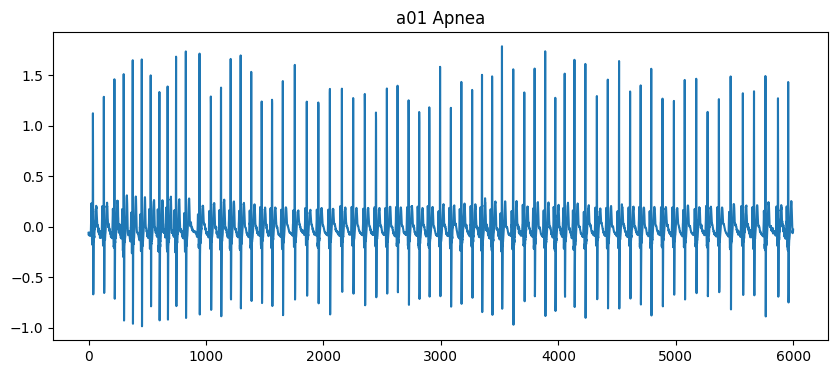

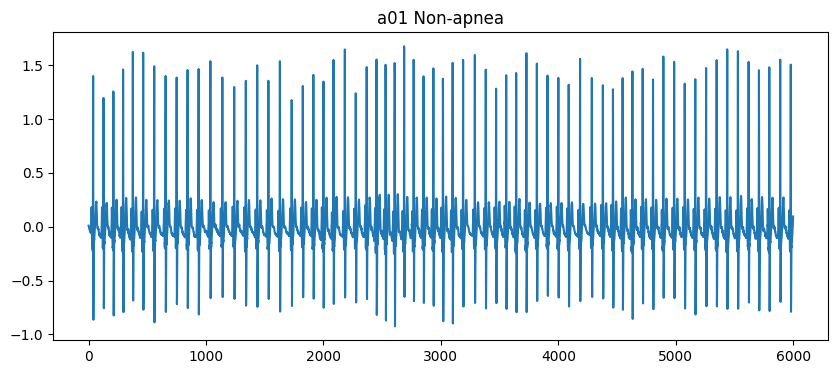

In [ ]:
rec0 = valid_records[0]
rec = wfdb.rdrecord(os.path.join(dataset_path, rec0))
ann = wfdb.rdann(os.path.join(dataset_path, rec0), 'apn')
sig = bandpass_filter(rec.p_signal[:,0], fs=FS)

ap_idx = next((i for i,s in enumerate(ann.symbol) if s=='A'), None)
na_idx = next((i for i,s in enumerate(ann.symbol) if s!='A'), None)

if ap_idx is not None:
    st,en = ann.sample[ap_idx], ann.sample[ap_idx+1]
    plt.plot(sig[st:en]); plt.title(f"{rec0} Apnea"); plt.show()
if na_idx is not None:
    st,en = ann.sample[na_idx], ann.sample[na_idx+1]
    plt.plot(sig[st:en]); plt.title(f"{rec0} Non-apnea"); plt.show()


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
classes = np.unique(y_train)
class_weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_train)
class_weight_dict = {int(c): float(w) for c,w in zip(classes, class_weights)}
print("Class weights:", class_weight_dict)
np.savez(dataset_path+"scaler_params.npz", mean=scaler.mean_, scale=scaler.scale_)


Class weights: {0: 0.8104106972301814, 1: 1.3053846153846154}


In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(3,)),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dense(8, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
history = model.fit(X_train, y_train, epochs=30, batch_size=64, validation_split=0.2,
                    class_weight=class_weight_dict, verbose=1)


Epoch 1/30
170/170 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.4940 - loss: 0.6940 - val_accuracy: 0.6395 - val_loss: 0.6760
Epoch 2/30
170/170 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6425 - loss: 0.6683 - val_accuracy: 0.6591 - val_loss: 0.6464
Epoch 3/30
170/170 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6705 - loss: 0.6424 - val_accuracy: 0.6859 - val_loss: 0.6103
Epoch 4/30
170/170 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6924 - loss: 0.6098 - val_accuracy: 0.7077 - val_loss: 0.5893
Epoch 5/30
170/170 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7128 - loss: 0.5873 - val_accuracy: 0.7191 - val_loss: 0.5803
Epoch 6/30
170/170 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7312 - loss: 0.5689 - val_accuracy: 0.7279 - val_loss: 0.5556
Epoch 7/30
170/170 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7334 - loss: 0.5589 - val_accuracy: 0.7349 - val_loss: 0.5556
Epoch 8/30
170/170 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7354 - loss: 0.5568 - val_accuracy: 0.

Test Accuracy: 0.7584683299064636
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
              precision    recall  f1-score   support

           0     0.8492    0.7397    0.7907      2094
           1     0.6531    0.7886    0.7145      1301

    accuracy                         0.7585      3395
   macro avg     0.7512    0.7642    0.7526      3395
weighted avg     0.7741    0.7585    0.7615      3395



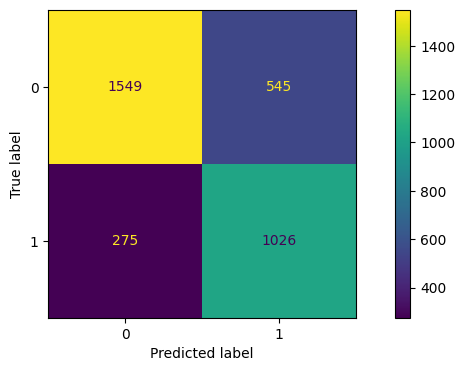

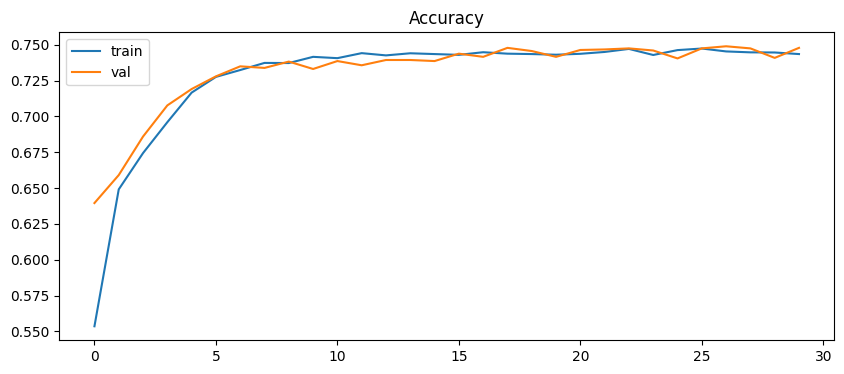

In [ ]:
loss, acc = model.evaluate(X_test, y_test, verbose=0)
print("Test Accuracy:", acc)
y_pred_prob = model.predict(X_test).ravel()
y_pred = (y_pred_prob>=0.5).astype(int)
print(classification_report(y_test, y_pred, digits=4))
cm = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(confusion_matrix=cm).plot()
plt.show()
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='val')
plt.legend(); plt.title("Accuracy"); plt.show()
